# The Beginning

we need the following packages:

* `numpy`: to manipulate in vector array
* `vaex`: to open and manipulate big data in dataframe
* `astroquery.gaia.Gaia`: to query Gaia DR3
* `astroquery.utils.tap.core.Tap`: to query 2MASS from Tap protocols

and some utility packages:

* `datetime`: to get the current time
* `time`: to get the current time
* `os.path`:
    * `join`: to join path
    * `abspath`: to get the absolute path

* `os`:
    * `mkdir`: to create a directory
    * `rmdir`: to remove a directory
    * `pardir`: to get the parent directory
* `sys`: to import local package
* `glob`: to get the list of files in a directory



In [1]:
import numpy as np
import vaex
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import Tap

from datetime import datetime
from time import time
from os.path import join, abspath
from os import pardir
from glob import glob
import sys

import some utility packages

* timeout: to set the timeout for the query
* append_name: append table name to the column name

In [2]:
# import utils
util_dir = join(abspath(pardir))
if not util_dir in sys.path:
    sys.path.insert(0, util_dir)
sys.path

['/home2/s20321005/Thesis-Project',
 '/home2/s20321005/Thesis-Project/1_Collecting_Data',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages']

# Begin > Utils Functions

In [3]:
import signal

class TimeoutError(Exception):
    pass

def timeout(func, duration, args=()):
    """
    Run a function with a time limit.

    Args:
        func (function): The function to run.
        duration (int): The maximum number of seconds to allow the function to run.
        args (tuple): The positional arguments to pass to the function. Defaults to an empty tuple.

    Returns:
        dict: A dictionary containing the results of the function call, or an error message if the function timed out or raised an exception.
        The dictionary has two keys:
            - "data": If the function completed successfully, this key maps to the return value of the function.
              If the function failed or timed out, this key maps to None.
            - "error": If the function failed or timed out, this key maps to a dictionary containing information about the error.
              The dictionary has two keys: "type" (a string with the name of the exception) and "message" (a string with the error message).

    Raises:
        TimeoutError: If the function takes longer than `duration` seconds to complete.

    Example usage:
        result = timeout(launch_job, 10, args=(arg1, arg2))
        if result["error"]:
            print("Error:", result["error"]["type"], result["error"]["message"])
        else:
            print("Result:", result["data"])
    """
    def handler(signum, frame):
        raise TimeoutError("Function timed out")

    # Set the signal handler for SIGALRM
    signal.signal(signal.SIGALRM, handler)
    signal.alarm(duration)

    try:
        result = func(*args)
        data = result
        error = None
    except TimeoutError:
        print("Function timed out")
        data = None
        error = {"type": "TimeoutError", "message": "Function timed out"}
    except Exception as e:
        data = None
        error = {"type": type(e).__name__, "message": str(e)}

    # Disable the alarm
    signal.alarm(0)

    return {"data": data, "error": error}

In [4]:
def launch_job(job_func, query, cols="", duration=10):
    """
    Launch a job with a timeout.

    Args:
        job_func (func): The job to launch.
        query (str): The query to run.
        cols (str): Rename the cols name if needed.
        duration (int): The timeout duration.

    Returns:
        df (vaex.dataframe): The dataframe or None.
    """
    # run the job and wrap in timeout
    job = timeout(job_func, args=(query,), duration=duration)
    df = None
    # print error if job failed
    if job['data'] == None:
        print(job['error'])
    # convert the result into vaex.dataframe if successful
    else:
        result = job['data'].get_results()
        df = result.to_pandas()
        if cols != "":
            df.columns = cols
        df = vaex.from_pandas(df)
    return df

In [5]:
def append_name(element, name):
    """
    Append a table name to a column name.
    
    Parameters:
    ----------
    element: str 
        The column name.
    name: str 
        The table name.

    Returns:
    -------
        str: The column name with the table name appended.
    
    Example usage:
    --------------
        [in]:  append_name("id", "users")

        [out]: users.\"id\"

        [in]:  append_name("id AS user_id", "users")

        [out]: users.\"id\" AS user_id
    """
    string = element.split(" AS ")
    if(len(string) == 1):
        return f"{name}.\"{element}\""
    else:
        return f"{name}.\"{string[0]}\" AS {string[1]}"

In [6]:
from os import mkdir

def safe_mkdir(path: str):
    """
    Create a directory if it doesn't exist

    Args:
        path (str): Path to the directory to create
    """
    try:
        mkdir(path)
        print(f"Creating {path} dir in Data dir")
    except FileExistsError:
        print(f"Directory {path} already exist. Good to go!")

In [7]:
import shutil
import os

def delete_directory(dir_path):
    """
    Deletes a directory and all its contents.
    
    Args:
        dir_path (str): The path to the directory to be deleted.
        
    Returns:
        bool: True if the directory was deleted successfully, False otherwise.
    """
    try:
        shutil.rmtree(dir_path)
        if os.path.exists(dir_path):
            return False
        else:
            return True
    except Exception as e:
        print("Error deleting directory:", e)
        return False


# End > Utils Functions

In [3]:
from utils import (launch_job, append_name, safe_mkdir, delete_directory, check_df)

In [4]:
# get the root of data directory
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [5]:
# Create a directory for Gaia DR3 and 2MASS data
# or if it already exists, just move on
ra_name = "Gaia-2MASS-test"
gaia_data_dir = join(root_data_dir, ra_name)
safe_mkdir(gaia_data_dir)

Creating /home2/s20321005/Thesis-Project/Data/Gaia-2MASS-test dir in Data dir


In [6]:
# Do the same for 2MASS data
ra_name = "TWOMASS-test"
tmass_data_dir = join(root_data_dir, ra_name)
safe_mkdir(tmass_data_dir)

Creating /home2/s20321005/Thesis-Project/Data/TWOMASS-test dir in Data dir


### defining columns

there are many columns and tables in Gaia DR3 that we need.

gaiadr3.gaia_source AS gdr3:
| Name | Description | Unit |
| --- | --- | --- |
| pm | proper motion | mas/yr |
| pmra | proper motion in right ascension (already corrected for declination) | mas/yr |
| pmdec | proper motion in declination | mas/yr |
| pmra_error (e_pmra) | error of proper motion in right ascension | mas/yr |
| pmdec_error (e_pmdec) | error of proper motion in declination | mas/yr |
| parallax | parallax | mas |
| parallax_error (e_parallax) | error of parallax | mas |
| phot_g_mean_mag (gmag) | mean magnitude in G band | mag |
| phot_bp_mean_mag (bpmag) | mean magnitude in BP band | mag |
| phot_rp_mean_mag (rpmag) | mean magnitude in RP band | mag |
| phot_bp_mean_flux_over_error (fb_over_err) | mean flux in BP band over error | - |
| phot_rp_mean_flux_over_error (fr_over_err) | mean flux in RP band over error | - |
| ruwe | robust estimator of the weighted scatter of the astrometric solution | - |
| phot_bp_rp_excess_factor (excess_factor) | excess factor of the BP-RP color | - |
| radial_velocity (rv_gaia) | radial velocity | km/s |
| radial_velocity_error (e_rv_gaia) | error of radial velocity | km/s |
| l (glon) | galactic longitude | deg |
| b (glat) | galactic latitude | deg |
| teff_gspphot | effective temperature according to gssphot | K |
| teff_gspphot_upper | upper error of effective temperature according to gssphot | K |
| teff_gspphot_lower | lower error of effective temperature according to gssphot | K |
| logg_gspphot | surface gravity according to gssphot | dex |
| logg_gspphot_upper | upper error of surface gravity according to gssphot | dex |
| logg_gspphot_lower | lower error of surface gravity according to gssphot | dex |

gaiadr3.astrophysical_parameters AS astrophysical:
| Name                    | Description                                                     | Unit  |
|-------------------------|-----------------------------------------------------------------|-------|
| `mh_gspphot`            | metallicity according to gssphot                                 | dex   |
| `mh_gspphot_upper`      | upper error of metallicity according to gssphot                  | dex   |
| `mh_gspphot_lower`      | lower error of metallicity according to gssphot                  | dex   |
| `distance_gspphot`      | distance according to gssphot                                    | pc    |
| `distance_gspphot_upper`| upper error of distance according to gssphot                     | pc    |
| `distance_gspphot_lower`| lower error of distance according to gssphot                     | pc    |
| `ag`                    | extinction in G band                                            | mag   |
| `ag_upper`              | upper error of extinction in G band                              | mag   |
| `ag_lower`              | lower error of extinction in G band                              | mag   |
| `mh_gspspec`            | metallicity according to gspspec                                  | dex   |
| `mh_gspspec_upper`      | upper error of metallicity according to gspspec                   | dex   |
| `mh_gspspec_lower`      | lower error of metallicity according to gspspec                   | dex   |
| `alphafe_gspspec`       | alpha abundance according to gspspec                              | dex   |
| `alphafe_gspspec_upper` | upper error of alpha abundance according to gspspec               | dex   |
| `alphafe_gspspec_lower` | lower error of alpha abundance according to gspspec               | dex   |
| `fem_gspspec`           | iron to metal abundance according to gspspec                      | dex   |
| `fem_gspspec_upper`     | upper error of iron to metal abundance according to gspspec       | dex   |
| `fem_gspspec_lower`     | lower error of iron to metal abundance according to gspspec       | dex   |
| `spectraltype_esphs`    | spectral type according to esphs                                  |       |



gaiadr3.tmass_psc_xsc_join AS join_table:
| Name                    | Description                                                     | Unit  |
|-------------------------|-----------------------------------------------------------------|-------|
|`original_psc_source_id`| crossmatch table from gaia to 2mass|

In [7]:
column_gaia = [
    "source_id", 
    "pm", "pmra", "pmra_error AS e_pmra", "pmdec", "pmdec_error AS e_pmdec", 
    "parallax", "parallax_error AS e_parallax", 
    "phot_g_mean_mag AS Gmag",	"phot_bp_mean_mag AS BPmag", "phot_rp_mean_mag AS RPmag", 
    "phot_bp_mean_flux_over_error AS Fb_over_err", 
    "phot_rp_mean_flux_over_error AS Fr_over_err", 
    "ruwe", 
    "phot_bp_rp_excess_factor AS excess_factor", 
    "radial_velocity AS rv_gaia", "radial_velocity_error AS e_rv_gaia",
    "l AS glon", "b AS glat", 
    "teff_gspphot", "teff_gspphot_lower", "teff_gspphot_upper",
    "logg_gspphot", "logg_gspphot_lower", "logg_gspphot_upper"
]

column_astrophysical = [
    "mh_gspphot", "mh_gspphot_lower", "mh_gspphot_upper", 
    "distance_gspphot", "distance_gspphot_lower", "distance_gspphot_upper", 
    "ag_gspphot", "ag_gspphot_lower", "ag_gspphot_upper",
    "mh_gspspec", "mh_gspspec_lower", "mh_gspspec_upper", 
    "alphafe_gspspec", "alphafe_gspspec_lower", "alphafe_gspspec_upper", 
    "fem_gspspec", "fem_gspspec_lower", "fem_gspspec_upper" , 
    "spectraltype_esphs"
]

column_join = ["original_psc_source_id AS tmass"]

gaia_alias = "gdr3"
astrophysical_alias = "astrophysical"
join_alias = "join_table"

column_gaia = list(map(lambda x: append_name(x, gaia_alias), column_gaia))
column_astrophysical = list(map(lambda x: append_name(x, astrophysical_alias), column_astrophysical))
column_join = list(map(lambda x: append_name(x, join_alias), column_join))

columns = column_gaia + column_astrophysical + column_join
columns

['gdr3."source_id"',
 'gdr3."pm"',
 'gdr3."pmra"',
 'gdr3."pmra_error" AS e_pmra',
 'gdr3."pmdec"',
 'gdr3."pmdec_error" AS e_pmdec',
 'gdr3."parallax"',
 'gdr3."parallax_error" AS e_parallax',
 'gdr3."phot_g_mean_mag" AS Gmag',
 'gdr3."phot_bp_mean_mag" AS BPmag',
 'gdr3."phot_rp_mean_mag" AS RPmag',
 'gdr3."phot_bp_mean_flux_over_error" AS Fb_over_err',
 'gdr3."phot_rp_mean_flux_over_error" AS Fr_over_err',
 'gdr3."ruwe"',
 'gdr3."phot_bp_rp_excess_factor" AS excess_factor',
 'gdr3."radial_velocity" AS rv_gaia',
 'gdr3."radial_velocity_error" AS e_rv_gaia',
 'gdr3."l" AS glon',
 'gdr3."b" AS glat',
 'gdr3."teff_gspphot"',
 'gdr3."teff_gspphot_lower"',
 'gdr3."teff_gspphot_upper"',
 'gdr3."logg_gspphot"',
 'gdr3."logg_gspphot_lower"',
 'gdr3."logg_gspphot_upper"',
 'astrophysical."mh_gspphot"',
 'astrophysical."mh_gspphot_lower"',
 'astrophysical."mh_gspphot_upper"',
 'astrophysical."distance_gspphot"',
 'astrophysical."distance_gspphot_lower"',
 'astrophysical."distance_gspphot_upper

Test gaia query

In [14]:
TOP = 1000
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
LEFT JOIN gaiadr3.astrophysical_parameters AS {astrophysical_alias} ON astrophysical.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_join as {join_alias} ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
WHERE gdr3.ra BETWEEN 0 AND 1
AND gdr3.dec BETWEEN 0 AND 1
"""
# test for timeout error
df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=2)
df_gaia

Function timed out
{'type': 'TimeoutError', 'message': 'Function timed out'}


In [15]:
# increase the timeout duration, should be working now
df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=10)
df_gaia

#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,tmass
0,2738301239023951872,15.452848,-2.4396361203715675,0.213626,-15.25905314657402,0.08839811,1.5546639904202617,0.15466519,17.89857,19.039177,16.878193,38.471077,143.97571,0.9964819,1.3310089,nan,nan,96.97304732424277,-59.444562933467886,5094.257,5023.718,5204.422,3.7555,3.6905,3.8066,-0.141,-0.25,-0.0424,2644.472,2498.6218,2834.452,2.106,2.0446,2.1876,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000015+0048353
1,2738215374037617280,16.528448,7.622902933696334,0.45880646,-14.66563928781094,0.3445331,1.9316520479956616,0.4761021,19.701853,20.95092,18.441822,8.090968,56.30646,1.0155579,1.5729879,nan,nan,96.61675636214513,-59.86845292011402,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000029+0020573
2,2738294646249950464,16.920013,15.727889485752868,0.030565234,-6.2386182378986526,0.020169798,0.7111678925386531,0.029599223,14.743093,15.096594,14.216369,565.61774,1347.9517,1.0475903,1.2074407,nan,nan,96.86294240272038,-59.577965704038135,5450.4346,5441.9224,5464.8667,4.2182,4.2039,4.2367,-0.7167,-0.7351,-0.6937,1233.3447,1195.9532,1262.7806,0.0072,0.0021,0.0158,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00000029+0039544
3,2738223208058015488,4.151558,-0.6464668177867251,0.3133622,-4.100916174464353,0.20489562,1.0249887525602555,0.27208024,19.067236,20.3389,17.999353,17.2238,64.74676,1.041015,1.350354,nan,nan,96.76009244969302,-59.70010809470707,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000033+0031565
4,2738223212353886336,3.2468765,-0.8893183875639226,0.100175604,-3.122710383878679,0.056938235,0.3968673345305549,0.0785026,17.077734,17.48083,16.532284,108.20531,225.85867,1.0158308,1.1959527,nan,nan,96.75568080515606,-59.70685893017676,5228.9937,5220.0737,5239.315,4.6324,4.6078,4.6513,-0.4984,-0.5504,-0.4493,1647.3835,1611.6805,1685.5164,0.0021,0.0005,0.0063,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,00000046+0031309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2738349999788572544,6.3607173,6.312159620749597,0.04976042,-0.7844519734167342,0.024988519,0.6486367108544879,0.037183046,13.985814,14.309882,13.4921465,1014.50806,1764.2107,1.8059769,1.2013278,32.311348,7.2830186,98.1800314014436,-59.59874511100543,5637.1553,5619.762,5654.2793,3.9416,3.9256,3.9544,-0.4926,-0.5074,-0.4812,1117.4271,1104.3173,1135.2659,0.0174,0.0078,0.0268,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00023010+0054020
996,2738349995493681792,7.13749,7.106839345414534,0.34193558,-0.6607552440056009,0.2225997,0.9643509107139575,0.30446807,19.02612,20.144407,18.081076,21.624804,45.393475,1.0065513,1.2640594,nan,nan,98.18313043744496,-59.598733900362475,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00023045+0054043
997,2546052975233206144,10.117639,-2.561369133529036,0.019812861,-9.78805364273433,0.010469069,0.5520039758830554,0.017639948,13.583392,14.08934,12.92118,1425.7131,2881.922,1.0662869,1.2297167,-12.123729,1.421052,97.6503228769986,-60.25646124365543,4908.696,4819.217,4942.209,3.0002,2.7621,3.1205,-0.2521,-0.2625,-0.2405,2147.195,1876.1539,2787.842,0.1603,0.0818,0.1916,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,00023050+0011288
998,2738350785766437632,21.199188,-4.4902258510394155,0.19513817,-20.71819059142849,0.123

Querying from tap API is a bit different. The resulting table has no column names.

We need to rename the table columns names

In [8]:
# 2MASS tap endpoint
tap_tmass = Tap(url="https://irsa.ipac.caltech.edu/TAP/sync")

columns_tmass = ["ra", "dec","j_m", "k_m", "designation", "ph_qual"]

# rename the table columns as 
columns_tmass_names = ["ra", "dec","Jmag", "Kmag", "designation", "ph_qual"]

tmass_table = "fp_psc"
column_tmass = list(map(lambda x: append_name(x, tmass_table), columns_tmass))
column_tmass

['fp_psc."ra"',
 'fp_psc."dec"',
 'fp_psc."j_m"',
 'fp_psc."k_m"',
 'fp_psc."designation"',
 'fp_psc."ph_qual"']

Test 2MASS endpoint

In [19]:
TOP = 1000
query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN 0 AND 1
AND dec BETWEEN 0 AND 1
"""
# should timeout
df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=2)

Function timed out
{'type': 'TimeoutError', 'message': 'Function timed out'}


In [20]:
df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=10)
df_tmass

#,ra,dec,Jmag,Kmag,designation,ph_qual
0,0.000664,0.809816,15.43,14.721,00000015+0048353,AAA
1,0.001234,0.349274,16.56,15.455,00000029+0020573,ABC
2,0.001245,0.665133,13.609,13.182,00000029+0039544,AAA
3,0.001414,0.532371,16.45,15.33,00000033+0031565,ACB
4,0.001945,0.52526,15.891,15.267,00000046+0031309,ABB
...,...,...,...,...,...,...
995,0.594102,0.392011,14.421,13.639,00022258+0023312,AAA
996,0.594154,0.312531,15.169,14.691,00022259+0018451,AAA
997,0.596997,0.579075,16.662,15.866,00022327+0034446,BDU
998,0.597254,0.709375,16.567,15.26,00022334+0042337,BCC


The crossmatch table being used have some information to be considered.

The crossmatch from Gaia to 2MASS (dense survey) can have mates. Two or more
Gaia objects with the same best neighbour in 2MASS are called mates. Therefore,
there can be duplicates in the crossmatch table.

`tmass_psc_xsc_best_neighbour` table contains gaia id `source_id` and `clean_tmass_psc_xsc_oid`.
This table contains every objects from Gaia that have companion in 2MASS.
Therefore, every gaia object in the table only have one 2MASS object.
`clean_tmass_psc_xsc_oid` column can be used to match with `tmass_psc_xsc_join` table.

2MASS catalog contains both stars (point sources) and galaxies (extended sources). `tmass_psc_xsc_join`
table contains `original_psc_source_id`. Therefore we can crossmatch:

> gaia_source.source_id == tmass_psc_xsc_best_neighbour.source_id (RIGHT)
> tmass_psc_xsc_best_neighbour.clean_tmass_psc_xsc_oid == tmass_psc_xsc_join.clean_tmass_psc_xsc_oid (LEFT or RIGHT)
> tmass_psc_xsc_join.original_psc_source_id == tmass.designation (LEFT)

The problem now is that, the 2MASS object matched to the Gaia object can the same. Ergo, duplicates.
One way to mitigate the problem is by choosing the first object in duplicates.
Illustration:

    gaia_id | tmass_id
    1       | 1
    2       | 1
    3       | 2
    4       | 3
    5       | 4
    6       | 4
Drop duplicates:

    gaia_id | tmass_id
    1       | 1
    3       | 2
    4       | 3
    5       | 4
    

crossmatch gaia and 2mass

In [21]:
TOP = 1000
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
LEFT JOIN gaiadr3.astrophysical_parameters AS {astrophysical_alias} ON astrophysical.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_join as {join_alias} ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
WHERE gdr3.ra BETWEEN 0 AND 1
AND gdr3.dec BETWEEN 0 AND 1
"""

df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=10)
    
query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN 0 AND 1
AND dec BETWEEN 0 AND 1
"""

df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=10)

df_table = df_gaia.join(df_tmass, right_on="designation", left_on="tmass", how="left")
df_table

#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,tmass,ra,dec,Jmag,Kmag,designation,ph_qual
0,2738301239023951872,15.452848,-2.4396361203715675,0.213626,-15.25905314657402,0.08839811,1.5546639904202617,0.15466519,17.89857,19.039177,16.878193,38.471077,143.97571,0.9964819,1.3310089,nan,nan,96.97304732424277,-59.444562933467886,5094.257,5023.718,5204.422,3.7555,3.6905,3.8066,-0.141,-0.25,-0.0424,2644.472,2498.6218,2834.452,2.106,2.0446,2.1876,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000015+0048353,0.000664,0.809816,15.43,14.721,00000015+0048353,AAA
1,2738215374037617280,16.528448,7.622902933696334,0.45880646,-14.66563928781094,0.3445331,1.9316520479956616,0.4761021,19.701853,20.95092,18.441822,8.090968,56.30646,1.0155579,1.5729879,nan,nan,96.61675636214513,-59.86845292011402,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000029+0020573,0.001234,0.349274,16.56,15.455,00000029+0020573,ABC
2,2738294646249950464,16.920013,15.727889485752868,0.030565234,-6.2386182378986526,0.020169798,0.7111678925386531,0.029599223,14.743093,15.096594,14.216369,565.61774,1347.9517,1.0475903,1.2074407,nan,nan,96.86294240272038,-59.577965704038135,5450.4346,5441.9224,5464.8667,4.2182,4.2039,4.2367,-0.7167,-0.7351,-0.6937,1233.3447,1195.9532,1262.7806,0.0072,0.0021,0.0158,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00000029+0039544,0.001245,0.665133,13.609,13.182,00000029+0039544,AAA
3,2738223208058015488,4.151558,-0.6464668177867251,0.3133622,-4.100916174464353,0.20489562,1.0249887525602555,0.27208024,19.067236,20.3389,17.999353,17.2238,64.74676,1.041015,1.350354,nan,nan,96.76009244969302,-59.70010809470707,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000033+0031565,0.001414,0.532371,16.45,15.33,00000033+0031565,ACB
4,2738223212353886336,3.2468765,-0.8893183875639226,0.100175604,-3.122710383878679,0.056938235,0.3968673345305549,0.0785026,17.077734,17.48083,16.532284,108.20531,225.85867,1.0158308,1.1959527,nan,nan,96.75568080515606,-59.70685893017676,5228.9937,5220.0737,5239.315,4.6324,4.6078,4.6513,-0.4984,-0.5504,-0.4493,1647.3835,1611.6805,1685.5164,0.0021,0.0005,0.0063,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,00000046+0031309,0.001945,0.52526,15.891,15.267,00000046+0031309,ABB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2738349999788572544,6.3607173,6.312159620749597,0.04976042,-0.7844519734167342,0.024988519,0.6486367108544879,0.037183046,13.985814,14.309882,13.4921465,1014.50806,1764.2107,1.8059769,1.2013278,32.311348,7.2830186,98.1800314014436,-59.59874511100543,5637.1553,5619.762,5654.2793,3.9416,3.9256,3.9544,-0.4926,-0.5074,-0.4812,1117.4271,1104.3173,1135.2659,0.0174,0.0078,0.0268,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00023010+0054020,--,--,--,--,--,--
996,2738349995493681792,7.13749,7.106839345414534,0.34193558,-0.6607552440056009,0.2225997,0.9643509107139575,0.30446807,19.02612,20.144407,18.081076,21.624804,45.393475,1.0065513,1.2640594,nan,nan,98.18313043744496,-59.598733900362475,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00023045+0054043,--,--,--,--,--,--
997,2546052975233206144,10.117639,-2.561369133529036,0.019812861,-9.78805364273433,0.010469069,0.5520039758830554,0.017639948,13.583392,14.08934,12.92118,142

But, querying ALL data is too much DATA (slow internet = bad). We need a better strategy. One way is to query the data according to their position in the sky. We can query from some RA and DEC range for both catalogs, then join the tables.

But, we need to be careful. The two catalogs may have slightly different coordinate system. To make sure
every object in 2MASS joined to Gaia, we can give more range in RA and DEC for 2MASS.

In [22]:
TOP = 1000
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
LEFT JOIN gaiadr3.astrophysical_parameters AS {astrophysical_alias} ON astrophysical.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_join as {join_alias} ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
WHERE gdr3.ra BETWEEN 0 AND 0.1
AND gdr3.dec BETWEEN 0 AND 0.1
"""

df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=10)
print("gaia: ", len(df_gaia))
query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN -0.1 AND 0.2
AND dec BETWEEN -0.1 AND 0.2
"""

df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=10)
print("tmass: ", len(df_tmass))

df_table = df_gaia.join(df_tmass, right_on="designation", left_on="tmass", how="left")
df_table

gaia:  11
tmass:  99


#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,tmass,ra,dec,Jmag,Kmag,designation,ph_qual
0,2738190261363834752,nan,nan,nan,nan,nan,nan,nan,21.206774,19.901033,18.391542,14.618735,22.232944,nan,8.041515,nan,nan,96.4252265874694,-60.11441184663786,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000259+0005072,0.010819,0.085355,16.84,15.856,00000259+0005072,CCD
1,2738189402371313536,24.489563,0.2235421139061587,0.08540153,-24.488543202676073,0.041835785,1.6185493076794253,0.065504305,16.613222,17.438858,15.7189665,164.80835,311.57825,1.0524493,1.2982227,nan,nan,96.42178639552206,-60.14181278325434,4198.347,4170.506,4226.2886,4.6701,4.6618,4.6804,0.0584,0.0053,0.1375,576.2736,561.851,593.2487,0.3414,0.3128,0.3677,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,00000480+0003350,0.020036,0.059739,14.557,13.806,00000480+0003350,AAA
2,2738188745240343552,14.690249,-9.282249009982245,0.13744329,-11.386099945128661,0.06628131,0.8263479780786821,0.10552607,17.364765,18.00437,16.604973,124.53133,148.70398,1.09727,1.2498498,nan,nan,96.42272203573486,-60.16196157984787,4323.9336,4310.5596,4345.1406,4.4015,4.3847,4.4458,-0.3972,-0.4403,-0.3433,1512.8055,1451.449,1543.9949,0.0038,0.0008,0.0111,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,00000683+0002288,0.028464,0.041338,15.749,14.816,00000683+0002288,AAA
3,2546034936370507392,53.83092,53.80102086344147,0.05314502,1.793957230040646,0.021066993,6.828829490743712,0.035262,15.031088,16.092154,14.005127,395.76547,1066.124,1.0320184,1.3558441,18.514708,3.7578015,96.41090544008978,-60.202732734001714,3795.7495,3787.6335,3840.5676,4.7789,4.6699,4.7887,-0.4065,-0.4424,-0.2037,146.8167,144.7157,180.4319,0.4392,0.429,0.4801,nan,nan,nan,nan,nan,nan,nan,nan,nan,M,00000935+0000055,0.038972,0.001536,12.682,11.844,00000935+0000055,AAA
4,2738189539810574080,45.44853,-18.048060627808546,0.09670794,-41.71134584570512,0.046627097,2.835518131408606,0.07095567,16.774633,17.926857,15.709566,128.28415,369.85077,1.0316745,1.3735807,nan,nan,96.48994554109956,-60.12527252252441,3638.9036,3628.5981,3649.657,4.5734,4.4247,4.633,-0.4568,-0.489,-0.428,385.2143,351.1896,481.1929,0.3437,0.3304,0.3583,nan,nan,nan,nan,nan,nan,nan,nan,nan,M,00001072+0005183,0.044682,0.088436,14.331,13.546,00001072+0005183,AAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2546035516189912192,0.22024563,0.22021081325784556,0.13663568,-0.003916356131951143,0.07339427,-0.009259253271187956,0.11804573,17.471752,17.499405,17.11613,48.956383,57.256275,1.0207223,1.291047,nan,nan,96.46151573227536,-60.17132657705381,7007.0664,6988.895,7024.1396,4.5895,4.5749,4.5964,-3.3229,-3.3749,-3.2095,4216.833,4163.766,4273.0693,0.0008,0.0002,0.0022,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00001197+0002253,0.049897,0.040369,16.651,14.821,00001197+0002253,BBB
7,2546035073809587456,nan,nan,nan,nan,nan,nan,nan,21.311394,20.673088,18.571123,8.352885,19.27899,nan,6.55748,nan,nan,96.44856659873795,-60.189836039004675,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00001231+0001150,0.051312,0.020844,16.664,15.385,00001231+0001150,CCC
8,2546034867651031168,7.281073,5.114631151080502,0.06850985,-5.182139871871228,0.034158,0.3758082284893357,0.053153638,16.063038,16.507826,15.453807,358.19595,493.05597,1.0705945,1.2

Querying without limits could be problematic. Ideally, we only querying subset with manageable size. But, if something wrong in the code, we could accidentally query a lot of data. This is not a desiredable situation. Therefore, we need to limit the query size. But what is the limit? If the limit is too small, we might miss some objects. If the limit is too big, we might query a lot of data. We need to find the balance.

One of the solutions is to make the limit dynamic. If the query result has the same number of rows as the limit, we can increase the limit. If the query result has less rows than the limit, we can adjust the limit well above the previous numbers.

This is my proposal:
1. set initial limit = 100_000
2. set for loops (range in RA and DEC)
3. query the data
4. if the query result has the same number of rows as the limit, increase the limit by 2 times, then go to step 2
5. if the query result has less rows than the limit, adjust the limit to be 2 times the rows, then go to step 2
6. save the data in a file
7. if we still need to query more data, go to step 2

My proposal is to divide the data into RA and DEC ranges. The ranges are chosen based on the data distribution. The ranges are:

    RA: 0-360 into 360 parts
    DEC: -90-90 into 180 parts

in total, 360x180 = 64800 parts. That's a lot of data to save. Not really convenient.

Let loops over DEC than RA. This way, we can create temporary directory for each DEC range. In each RA iteration, we can save the data into the temporary directory. After the iteration, we can combine all the files into one file, then remove the temporary directory.

Doing this way, we can make sure every data is save and can be resumed if the process is interrupted.

There are three combination of the results from the query. 
1. The query result is empty. 
    * in this case, we stop the program and investigate the problem.
2. The query result has the same number of rows as the limit.
    * in this case, we can adjust the limit to be 2 times previous limit
3. The query result has less rows than the limit.
    * this is the desired case. We accept the result. But, for efficiency, intuitively, the next result should have roughly about the same number of rows as the previous result. Therefore, the limit of 2 times the number of rows is a good lower bound choice. If the previous limit is less than 2 times the number of rows, we can adjust the limit to be 2 times the number of rows.

In [38]:
def check_df(df, top):
    """
    Check if the dataframe is None, capped, or empty

    Args:
        df (DataFrame-like): the dataframe to check
        top (int): the top number of rows to query
    
    Returns:
        {force_break: bool, retry: bool, prev_top: int, new_top: int}
    """
    new_top = top # default new top
    if df is None:
        # if the dataframe is None, therefore the query failed for some reason
        return {
            "force_break": True,
            "retry": False,
            "prev_top": top,
            "new_top": top
        }
    elif len(df) == top:
        # if the dataframe is capped, double the top number of rows to query
        new_top = 2*top
        return {
            "force_break": False,
            "retry": True,
            "prev_top": top,
            "new_top": new_top
        }
    elif len(df) == 0:
        # if the dataframe is empty, it means that there is something wrong.
        # let's force the break and investigate further
        return {
            "force_break": True,
            "retry": False,
            "prev_top": top,
            "new_top": top
        }
    if top > 2*len(df):
        # just for good measure.
        new_top = 2*len(df)
    # no problem, return the new top number of rows to query. Let's go!
    return {
        "force_break": False,
        "retry": False,
        "prev_top": top,
        "new_top": new_top
    }

In [39]:
# def point_in_time(t0):
#     t1 = time()
#     d1 = datetime.now()
#     print(f"======= {d1} | {t1-t0} s =======")

In [27]:
df_tmass = []
df_gaia = []
df_tmass_only = []

def iterate_job(ras, decs, gen_gaia_query, gen_tmass_query, path_gaia, path_tmass, 
                columns_tmass_names, gaia_top=100_000, tmass_top=100_000, timeout=300, 
                start_dec=-999, num_tries=10):
    """
    Iterate through the RAs and Decs to query the Gaia and TMASS databases
    Args:
        ras (array-like): the RAs to iterate through
        decs (array-like): the Decs to iterate through
        gen_gaia_query (str): the query to run on the Gaia database
        gen_tmass_query (str): the query to run on the TMASS database
        path_gaia (str): the path to save the Gaia dataframes
        path_tmass (str): the path to save the TMASS dataframes
        columns_tmass_names (list): the columns to query from the TMASS database
        gaia_top (int): the top number of rows to query from the Gaia database
        tmass_top (int): the top number of rows to query from the TMASS database
        timeout (int): the timeout for the query
        start_dec (float): the starting dec to start the query from for the first ra
        num_tries (int): the number of tries to query the database before giving up
    """
    # keep track of the old top for recording purposes
    old_gaia_top = gaia_top
    old_tmass_top = tmass_top
    # keep track the force_break flag
    force_break = False
    # loop through the RAs
    for i, (ra0, ra1) in enumerate(zip(ras[:-1], ras[1:])):
        if force_break: break
        # create the directory to save the dataframes
        ra_name = f"ra_{ra0:03d}-{ra1:03d}"
        safe_mkdir(join(path_gaia, ra_name))
        safe_mkdir(join(path_tmass, ra_name))
        # loop through the Decs
        time0 = time()
        date0 = datetime.now()
        print(f"RA: {ra0:03d}-{ra1:03d} {date0}")
        for j, (dec0, dec1) in enumerate(zip(decs[:-1], decs[1:])):
            t0 = time()
            d0 = datetime.now()
            print(f"\tDEC: {dec0:02d}-{dec1:02d} {d0}")
            # keep track of the number of tries
            tries = 0
            # if the starting dec is not -999, then we are continuing from the previous query
            if (ra0 == ras[0]) and (dec0 < start_dec): 
                continue
            if force_break: break
            # loop over the queries until we get a dataframe that is not capped or empty or failed
            while True:
                try_log =  f"RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d})"
                # increment the number of tries
                tries += 1
                # if we have tried too many times, then something is wrong. Let's force the break
                if tries > num_tries:
                    force_break = True
                    print(f"\n\tGaia {try_log} have tried {num_tries} times, something wrong")
                    # point_in_time(t0)
                if force_break: break
                # sql query to query the Gaia database
                query_gaia = gen_gaia_query(ra0, ra1, dec0, dec1, gaia_top)
                # launch the job to query the Gaia database
                df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=timeout)
                # check the result
                res_gaia = check_df(df_gaia, gaia_top)
                # if something is wrong, let's force the break
                force_break = res_gaia['force_break']
                if force_break: 
                    print(f"\n\tGaia {try_log} is empty")
                    # point_in_time(t0)
                    break
                # if failed, let's retry with a larger top
                retry = res_gaia['retry']
                old_gaia_top = res_gaia['prev_top']
                gaia_top = res_gaia['new_top']
                if retry: 
                    print(f"\n\tGaia  {try_log} is capped at {old_gaia_top}, increasing to {gaia_top}")
                    # point_in_time(t0)
                    continue
                # if everything is fine, let's continue the journey
                print(f"\n\tGaia {try_log} has {len(df_gaia)} rows | TOP={gaia_top}")
                # point_in_time(t0)
                # sql query to query the TMASS database
                query_tmass = gen_tmass_query(ra0, ra1, dec0, dec1, tmass_top)
                # launch the job to query the TMASS database
                df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=timeout)
                # check the result
                res_tmass = check_df(df_tmass, tmass_top)
                # if something is wrong, let's force the break
                force_break = res_tmass['force_break']
                if force_break: 
                    print(f"\t2MASS {try_log} is empty")
                    # point_in_time(t0)
                    break
                # if failed, let's retry with a larger top
                retry = res_tmass['retry']
                old_tmass_top = res_tmass['prev_top']
                tmass_top = res_tmass['new_top']
                if retry: 
                    print(f"\t2MASS {try_log} is capped at {old_tmass_top}, increasing to {tmass_top}")
                    # point_in_time(t0)
                    continue
                # if everything is fine, let's continue the journey
                print(f"\t2MASS {try_log} has {len(df_tmass)} rows | TOP={tmass_top}")
                # point_in_time(t0)
                # ===========================
                # this is to get the tmass only
                # because we are querying a larger area, we need to filter the result
                df_tmass_only = df_tmass.filter(f"ra > {ra0}").filter(f"ra < {ra1}").filter(f"dec > {dec0}").filter(f"dec < {dec1}")
                df_tmass_only = df_tmass_only.extract()
                # to avoid this random stup*d error
                # RuntimeError: Oops, get an empty chunk, from 1024 to 1024, that should not happen
                # convert to pandas, then back to vaex
                a = df_tmass_only.to_pandas_df()
                df_tmass_only = vaex.from_pandas(a)
                # ===========================   
                # join the gaia and tmass
                df_join = df_gaia.join(df_tmass, right_on="designation", left_on="tmass", how="left")
                # delete the columns that are not needed
                df_join.drop(columns=["designation", "tmass"], inplace=True)
                # save the result to the disk
                df_join.export(join(path_gaia, ra_name, f"dec_({dec0})-({dec1}).hdf5"), progress=True)
                print(f"\tgaia&tmass RA:{ra0:03}-{ra1:03}, DEC:({dec0})-({dec1}) is complete with rows {len(df_join)}")
                # point_in_time(t0)
                df_tmass_only.export(join(path_tmass, ra_name, f"dec_({dec0})-({dec1}).hdf5"), progress=True)
                # do the same for the tmass only
                print(f"\ttmass ONLY RA:{ra0:03}-{ra1:03}, DEC:({dec0})-({dec1}) is complete with rows {len(df_tmass_only)}")
                # point_in_time(t0)
                # get out of the while loop
                break
        # after looping for all decs, let's combine them
        df_gaia_tmass = vaex.open_many(glob(join(path_gaia, ra_name, "*.hdf5")))
        # save
        df_gaia_tmass.export(join(path_gaia, f"gaia-{ra0:03d}-{ra1:03d}.hdf5"), progress=True)
        # delete the temporary directory
        check_delete = delete_directory(join(path_gaia, ra_name))
        # check if the directory is deleted
        if not check_delete:
            force_break = True
            print(join(path_gaia, f"{ra_name}.txt"), f"Error deleting directory {ra_name}! Stopping loop.")
            # point_in_time(time0)
            break
        # tell the world that everything is fine
        print(f"gaia&tmass RA:{ra0:03}-{ra1:03} is complete with rows {len(df_gaia_tmass)}")
        # point_in_time(time0)
        # do the same for the tmass only
        df_tmass_only = vaex.open_many(glob(join(path_tmass, ra_name, "*.hdf5")))
        df_tmass_only.export(join(path_tmass, f"tmass-{ra0:03d}-{ra1:03d}.hdf5"), progress=True)
        check_delete = delete_directory(join(path_tmass, ra_name))
        if not check_delete:
            force_break = True
            print(join(path_tmass, f"{ra_name}.txt"), f"Error deleting directory {ra_name}! Stopping loop.")
            # point_in_time(time0)
            break
        print(f"tmass only RA:{ra0:03}-{ra1:03} is complete with rows {len(df_tmass_only)}\n")
        # point_in_time(time0)
        # loop again over the next ra

In [10]:
ras = np.arange(11,12+0.1, 1).astype(int)
decs = np.arange(-34,-33+0.1,1).astype(int)

def gen_gaia_query(ra0, ra1, dec0, dec1, top):
    return f"""SELECT TOP {top} {', '.join(columns)}
    FROM gaiadr3.gaia_source AS {gaia_alias}
    LEFT JOIN gaiadr3.astrophysical_parameters AS {astrophysical_alias} ON astrophysical.source_id = gdr3.source_id
    RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
    RIGHT JOIN gaiadr3.tmass_psc_xsc_join as {join_alias} ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
    WHERE ra BETWEEN {ra0} AND {ra1} 
    AND dec BETWEEN {dec0} AND {dec1}
    """

def gen_tmass_query(ra0, ra1, dec0, dec1, top):
    return f"""SELECT TOP {top} {", ".join(columns_tmass)} 
    FROM {tmass_table}
    WHERE ra BETWEEN {ra0-0.5} AND {ra1+0.5}
    AND dec BETWEEN {dec0-0.5} AND {dec1+0.5}
    """
ras, decs

(array([11, 12]), array([-34, -33]))

In [28]:
iterate_job(ras, decs, gen_gaia_query, gen_tmass_query, gaia_data_dir, tmass_data_dir, 
            columns_tmass_names, gaia_top=100_000, tmass_top=100_000, timeout=300, 
            start_dec=-999, num_tries=10)

Directory /home2/s20321005/Thesis-Project/Data/Gaia-2MASS-test/ra_011-012 already exist. Good to go!
Directory /home2/s20321005/Thesis-Project/Data/TWOMASS-test/ra_011-012 already exist. Good to go!
RA: 011-012 2023-05-15 18:52:35.420912
	DEC: -34--33 2023-05-15 18:52:35.420979

	Gaia RA:011-012, DEC:(-34)-(-33) has 979 rows | TOP=1958
	2MASS RA:011-012, DEC:(-34)-(-33) has 4420 rows | TOP=8840
export(hdf5) [########################################] 100.00% elapsed time  :     0.27s =  0.0m =  0.0h
 	gaia&tmass RA:011-012, DEC:(-34)-(-33) is complete with rows 979
export(hdf5) [########################################] 100.00% elapsed time  :     0.05s =  0.0m =  0.0h
 	tmass ONLY RA:011-012, DEC:(-34)-(-33) is complete with rows 1024
export(hdf5) [########################################] 100.00% elapsed time  :     0.21s =  0.0m =  0.0h 
 gaia&tmass RA:011-012 is complete with rows 979
export(hdf5) [########################################] 100.00% elapsed time  :     0.06s =  0.0m =

In [18]:
dec0 = -34
dec1 = -33
ra0 = 11
ra1 = 12
gaia_top = 100_000
tmass_top = 100_000
timeout = 60

query_gaia = gen_gaia_query(ra0, ra1, dec0, dec1, gaia_top)
# launch the job to query the Gaia database
df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=timeout)
# check the result
res_gaia = check_df(df_gaia, gaia_top)
# if something is wrong, let's force the break
force_break = res_gaia['force_break']
if force_break: 
    print(f"\n\tGaia is empty")
# if failed, let's retry with a larger top
retry = res_gaia['retry']
old_gaia_top = res_gaia['prev_top']
gaia_top = res_gaia['new_top']
if retry: 
    print(f"\n\tGaia is capped at {old_gaia_top}, increasing to {gaia_top}")
# if everything is fine, let's continue the journey
print(f"\n\tGaia has {len(df_gaia)} rows | TOP={gaia_top}")
# point_in_time(t0)
# sql query to query the TMASS database
query_tmass = gen_tmass_query(ra0, ra1, dec0, dec1, tmass_top)
# launch the job to query the TMASS database
df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=timeout)
# check the result
res_tmass = check_df(df_tmass, tmass_top)
# if something is wrong, let's force the break
retry = res_tmass['retry']
old_tmass_top = res_tmass['prev_top']
tmass_top = res_tmass['new_top']
# if everything is fine, let's continue the journey
print(f"\t2MASS has {len(df_tmass)} rows | TOP={tmass_top}")
# point_in_time(t0)
# ===========================
# this is to get the tmass only
# because we are querying a larger area, we need to filter the result
df_tmass_only = df_tmass.filter(f"ra > {ra0}").filter(f"ra < {ra1}").filter(f"dec > {dec0}").filter(f"dec < {dec1}")
df_tmass_only = df_tmass_only.extract()
# ===========================   
# join the gaia and tmass
df_join = df_gaia.join(df_tmass, right_on="designation", left_on="tmass", how="left")
# delete the columns that are not needed
df_join.drop(columns=["designation", "tmass"], inplace=True)


	Gaia has 979 rows | TOP=1958
	2MASS has 4420 rows | TOP=8840


#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,ra,dec,Jmag,Kmag,ph_qual
0,5006272188693764480,25.881508,25.87940633115308,0.59455925,-0.3298329350977657,0.46031117,2.049412546040849,0.3859044,19.479687,20.900537,18.239414,8.02105,59.495518,1.0557042,1.5151731,nan,nan,316.8325729762962,-83.52766118327081,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,11.000524,-33.39867,16.387,15.459,ACC
1,5006272360492460416,12.353131,-6.017497389927294,0.39562958,10.788400675717241,0.2940971,4.249156326170408,0.2556005,19.082079,20.720028,17.75842,7.887264,55.39603,0.98654395,1.5849715,nan,nan,316.8668118219386,-83.54233916405768,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,11.000696,-33.383556,15.795,14.857,AAA
2,5006272364788288384,17.968739,-4.840249081457927,0.015554671,-17.30455312925456,0.014522816,2.7574034968548418,0.01352037,10.720402,10.967661,10.313985,2189.436,4852.0156,0.92771965,1.189557,5.002669,0.3120724,316.87941382607727,-83.54822842945974,6209.1367,6193.813,6223.046,4.0062,3.9981,4.01,-0.4501,-0.4631,-0.4374,361.7601,359.5354,366.9255,0.0105,0.0023,0.0179,-0.3,-0.35,-0.24,0.32,0.24,0.43,0.01,-0.21,0.15,F,11.000862,-33.377396,9.878,9.593,AAA
3,5006302425263603072,10.230598,8.05320865471344,0.060675204,-6.309594465858185,0.070022315,0.4077170660983986,0.06838203,17.032448,17.492155,16.418238,186.5118,241.17017,0.9639873,1.2160147,nan,nan,317.45321468351636,-83.78285625325518,4961.4717,4946.2583,4978.0054,4.4934,4.465,4.516,-0.3743,-0.4212,-0.3286,1741.4481,1674.4619,1836.0886,0.0006,1e-04,0.002,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,11.001137,-33.134464,15.691,15.06,AAB
4,5006274048415466624,39.62228,32.001703473268954,0.015813133,-23.362704941033346,0.015312383,1.9717723096027606,0.015182628,13.570873,13.923272,13.052158,1741.4764,1521.555,1.0319531,1.202947,-3.3028622,2.9666595,317.1074319369728,-83.65351824625826,5447.473,5445.7627,5449.369,4.4351,4.4309,4.4391,-0.519,-0.5268,-0.5115,493.2722,489.6659,497.0734,0.0005,1e-04,0.0013,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,11.003885,-33.269123,12.428,12.066,AAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,5006596372825617536,9.451533,-5.293269780841161,0.16276602,-7.830247967166388,0.15892017,0.6842038814650301,0.13880053,18.21406,18.794975,17.555641,43.47655,117.36791,1.000151,1.1966524,nan,nan,309.53588734104653,-83.6722837349411,4561.6777,4550.872,4575.0176,4.6954,4.6644,4.7314,-0.8864,-1.0083,-0.7675,1633.4547,1547.6456,1718.3372,0.0008,1e-04,0.0026,nan,nan,nan,nan,nan,nan,nan,nan,nan,,11.989455,-33.411297,16.949,15.869,CDD
975,5006622421802710400,12.590373,4.136245789024968,0.1423591,-11.891549967532852,0.17914435,0.3743014953645126,0.17100392,18.285034,18.822287,17.622894,64.78428,67.88284,1.0190394,1.2167314,nan,nan,309.8870306726123,-83.99243568882441,4634.7227,4620.6074,4658.732,4.8378,4.7434,4.8846,-1.4648,-1.7384,-0.9898,1416.2649,1314.4305,1641.0065,0.0039,0.0007,0.0131,nan,nan,nan,nan,nan,nan,nan,nan,nan,,11.992637,-33.088688,16.691,15.69,BUU
976,5006610189735852416,42.577003,39.631213703928594,0.021681327,-15.561752515724985,0.02442226,0.7124430327630487,0.025343014,14.325352,14.57544,13.912325,1120.3326,991.6829,1.0351112,1.191791,118.74942,12.110964,309.83381122028834,-83.94934400914104,62

In [19]:
df_gaia

#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,tmass
0,5006272188693764480,25.881508,25.87940633115308,0.59455925,-0.3298329350977657,0.46031117,2.049412546040849,0.3859044,19.479687,20.900537,18.239414,8.02105,59.495518,1.0557042,1.5151731,nan,nan,316.8325729762962,-83.52766118327081,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00440012-3323552
1,5006272360492460416,12.353131,-6.017497389927294,0.39562958,10.788400675717241,0.2940971,4.249156326170408,0.2556005,19.082079,20.720028,17.75842,7.887264,55.39603,0.98654395,1.5849715,nan,nan,316.8668118219386,-83.54233916405768,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00440016-3323008
2,5006272364788288384,17.968739,-4.840249081457927,0.015554671,-17.30455312925456,0.014522816,2.7574034968548418,0.01352037,10.720402,10.967661,10.313985,2189.436,4852.0156,0.92771965,1.189557,5.002669,0.3120724,316.87941382607727,-83.54822842945974,6209.1367,6193.813,6223.046,4.0062,3.9981,4.01,-0.4501,-0.4631,-0.4374,361.7601,359.5354,366.9255,0.0105,0.0023,0.0179,-0.3,-0.35,-0.24,0.32,0.24,0.43,0.01,-0.21,0.15,F,00440020-3322386
3,5006302425263603072,10.230598,8.05320865471344,0.060675204,-6.309594465858185,0.070022315,0.4077170660983986,0.06838203,17.032448,17.492155,16.418238,186.5118,241.17017,0.9639873,1.2160147,nan,nan,317.45321468351636,-83.78285625325518,4961.4717,4946.2583,4978.0054,4.4934,4.465,4.516,-0.3743,-0.4212,-0.3286,1741.4481,1674.4619,1836.0886,0.0006,1e-04,0.002,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00440027-3308040
4,5006274048415466624,39.62228,32.001703473268954,0.015813133,-23.362704941033346,0.015312383,1.9717723096027606,0.015182628,13.570873,13.923272,13.052158,1741.4764,1521.555,1.0319531,1.202947,-3.3028622,2.9666595,317.1074319369728,-83.65351824625826,5447.473,5445.7627,5449.369,4.4351,4.4309,4.4391,-0.519,-0.5268,-0.5115,493.2722,489.6659,497.0734,0.0005,1e-04,0.0013,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00440093-3316088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,5006596372825617536,9.451533,-5.293269780841161,0.16276602,-7.830247967166388,0.15892017,0.6842038814650301,0.13880053,18.21406,18.794975,17.555641,43.47655,117.36791,1.000151,1.1966524,nan,nan,309.53588734104653,-83.6722837349411,4561.6777,4550.872,4575.0176,4.6954,4.6644,4.7314,-0.8864,-1.0083,-0.7675,1633.4547,1547.6456,1718.3372,0.0008,1e-04,0.0026,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00475746-3324406
975,5006622421802710400,12.590373,4.136245789024968,0.1423591,-11.891549967532852,0.17914435,0.3743014953645126,0.17100392,18.285034,18.822287,17.622894,64.78428,67.88284,1.0190394,1.2167314,nan,nan,309.8870306726123,-83.99243568882441,4634.7227,4620.6074,4658.732,4.8378,4.7434,4.8846,-1.4648,-1.7384,-0.9898,1416.2649,1314.4305,1641.0065,0.0039,0.0007,0.0131,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00475823-3305192
976,5006610189735852416,42.577003,39.631213703928594,0.021681327,-15.561752515724985,0.02442226,0.7124430327630487,0.025343014,14.325352,14.57544,13.912325,1120.3326,991.6829,1.0351112,1.191791,118.74942,12.110964,309.83381122028834,-83.94934400914104,6229.636,6181.893,6313.3286,4.1838,4.1152,4.2622,-1.4889,-1.4971,-1.4748,1280.1755,1146.1885,1421.1998,0.0597,0.0403,0.0963,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,00475821-3307561
977,500

In [20]:
df_tmass

#,ra,dec,Jmag,Kmag,designation,ph_qual
0,10.500105,-32.967701,15.871,15.332,00420002-3258037,AAC
1,10.500134,-34.083687,16.647,15.105,00420003-3405012,BBC
2,10.500733,-32.63662,15.787,15.529,00420017-3238118,ABC
3,10.501126,-33.799397,16.919,15.704,00420027-3347578,CDD
4,10.501516,-33.941376,16.801,15.122,00420036-3356289,BDU
...,...,...,...,...,...,...
"4,415",12.498572,-33.730888,16.268,15.242,00495965-3343511,BCC
"4,416",12.498644,-34.063778,17.034,15.656,00495967-3403496,CDD
"4,417",12.498813,-33.418926,16.547,15.565,00495971-3325081,BUD
"4,418",12.499268,-33.095966,16.261,15.361,00495982-3305454,ACC


In [24]:
a = df_tmass_only.to_pandas_df()
a

,ra,dec,Jmag,Kmag,designation,ph_qual
0,11.000524,-33.398670,16.386999,15.459,00440012-3323552,ACC
1,11.000696,-33.383556,15.795000,14.857,00440016-3323008,AAA
2,11.000862,-33.377396,9.878000,9.593,00440020-3322386,AAA
3,11.001137,-33.134464,15.691000,15.060,00440027-3308040,AAB
4,11.003885,-33.269123,12.428000,12.066,00440093-3316088,AAA
...,...,...,...,...,...,...
1019,11.992548,-33.132275,13.434000,13.100,00475821-3307561,AAA
1020,11.992637,-33.088688,16.691000,15.690,00475823-3305192,BUU
1021,11.992708,-33.425858,16.268999,15.299,00475824-3325330,ABC
1022,11.995143,-33.943432,14.172000,13.329,00475883-3356363,AAA


In [25]:
b = vaex.from_pandas(a)
b

#,ra,dec,Jmag,Kmag,designation,ph_qual
0,11.000524,-33.39867,16.387,15.459,00440012-3323552,ACC
1,11.000696,-33.383556,15.795,14.857,00440016-3323008,AAA
2,11.000862,-33.377396,9.878,9.593,00440020-3322386,AAA
3,11.001137,-33.134464,15.691,15.06,00440027-3308040,AAB
4,11.003885,-33.269123,12.428,12.066,00440093-3316088,AAA
...,...,...,...,...,...,...
"1,019",11.992548,-33.132275,13.434,13.1,00475821-3307561,AAA
"1,020",11.992637,-33.088688,16.691,15.69,00475823-3305192,BUU
"1,021",11.992708,-33.425858,16.269,15.299,00475824-3325330,ABC
"1,022",11.995143,-33.943432,14.172,13.329,00475883-3356363,AAA


# Check the Data

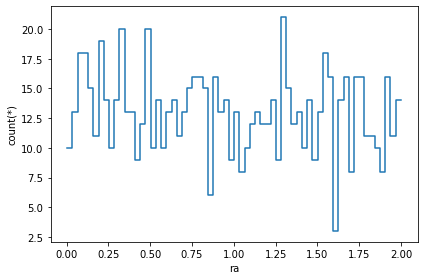

In [43]:
# check the data
tmass = vaex.open_many(glob(join(tmass_data_dir, "*.hdf5")))
tmass.viz.histogram("ra")

In [44]:
tmass

#,ra,dec,Jmag,Kmag,designation,ph_qual
0,1.026885,-89.175842,11.901,11.433,00040645-8910330,AAA
1,1.076087,-89.012215,16.695,15.64,00041826-8900439,CDD
2,1.112842,-89.039803,15.765,15.183,00042708-8902232,ABC
3,1.119851,-89.91861,12.467,11.963,00042876-8955069,AAA
4,1.126831,-89.655006,16.695,15.314,00043043-8939180,CDU
...,...,...,...,...,...,...
828,0.96741,-88.64447,14.898,14.432,00035217-8838400,AAA
829,0.970521,-88.709099,16.314,14.861,00035292-8842327,BBB
830,0.975295,-88.220215,15.019,14.441,00035407-8813127,AAA
831,0.978394,-88.385124,13.256,12.921,00035481-8823064,AAA


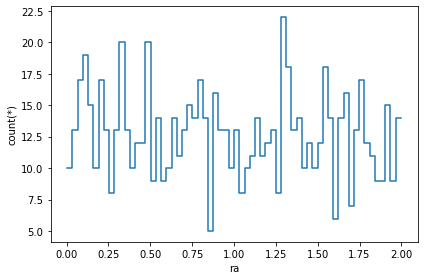

In [45]:
gaia = vaex.open_many(glob(join(gaia_data_dir, "*.hdf5")))
gaia.viz.histogram("ra")

In [82]:
gaia

#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,ra,dec,jmag,kmag,ph_qual
0,6341071024116923392,27.181486,26.219907673498525,0.1619937,7.165867662690853,0.15926693,0.8462159280166782,0.12653747,18.468872,19.508224,17.452581,25.009687,77.59609,0.98283386,1.3517543,nan,nan,302.9676499367185,-27.26768267853092,3799.133,3732.1882,3952.4932,4.3191,4.2565,4.3851,-0.6771,-0.779,-0.3774,1328.1719,1110.3856,1523.1396,0.5527,0.454,0.6938,nan,nan,nan,nan,nan,nan,nan,nan,nan,,nan,nan,nan,nan,--
1,4611690760072888960,6.8924713,-6.16283580475118,0.43619978,3.0863599386693785,0.40768367,1.1372669643805726,0.34071845,19.688269,20.921812,18.517662,7.7283173,34.448048,1.0588416,1.4700757,nan,nan,302.9628286548731,-27.25695019518819,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,0.783867,-89.868309,16.567,14.901,BUU
2,4611708008660299264,17.08801,15.516851761166475,0.081242345,-7.157333249113848,0.07781357,1.2855724542192457,0.06615926,17.507706,18.50154,16.532976,61.309105,194.06754,0.9743772,1.3233652,nan,nan,303.0014568841523,-27.404831574405826,4000.4795,3970.193,4025.0796,4.6917,4.6815,4.7024,-0.1676,-0.2143,-0.133,624.159,607.684,638.4129,0.513,0.4907,0.5373,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,0.268558,-89.71653,15.169,14.209,AAA
3,4611709181188492928,6.5878043,4.821691903032647,0.034149557,-4.4889254028881815,0.034355145,0.8222923699537003,0.030214705,15.962487,16.491627,15.286262,229.36317,409.8019,0.9597021,1.2301626,nan,nan,303.01551745721014,-27.46239540245029,4887.0454,4839.9053,5161.509,4.1988,4.1877,4.273,-0.6894,-0.7505,-0.4165,1388.719,1307.4613,1527.9545,0.2559,0.2211,0.4355,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,0.34258,-89.657608,14.428,13.751,AAA
4,4611709387346922880,12.490191,12.39432274452295,0.057449825,1.5445518674661234,0.057337705,0.6999401747378959,0.049945816,16.996668,17.514515,16.347021,129.61122,278.62268,1.0217737,1.2158437,nan,nan,303.0176640705403,-27.47153258215086,4913.182,4848.237,4982.7627,4.7116,4.6903,4.7365,-0.9876,-1.0736,-0.8543,1057.1335,1004.3998,1115.8271,0.1751,0.125,0.2253,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,0.363665,-89.648338,15.516,14.838,AAB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,4612886822564461824,61.342426,56.92306878079999,0.1249683,22.861701753408674,0.12232917,6.842426813094137,0.09899294,17.847067,19.903294,16.506058,18.422266,258.6981,1.0231612,1.5566264,nan,nan,303.38300854090386,-29.041089333818462,3127.656,3126.7273,3129.291,4.9635,4.9613,4.966,0.065,0.0563,0.0735,146.8128,145.5035,148.0269,0.7481,0.7366,0.7594,nan,nan,nan,nan,nan,nan,nan,nan,nan,,1.20566,-88.046265,14.502,13.663,AAA
813,4612886861220777088,2.4308429,-1.863307704177515,0.021097505,-1.5611155571106174,0.021909082,0.872861443704937,0.01782017,14.847667,15.243402,14.285301,717.40906,1361.9264,0.9901175,1.210279,nan,nan,303.3603091361332,-29.054622345682514,5427.8994,5405.3057,5450.979,4.296,4.2849,4.3064,-0.3573,-0.3825,-0.3333,1089.6416,1071.1868,1110.5289,0.139,0.1263,0.1508,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,1.860193,-88.036919,13.57,13.184,AAA
814,4612886895580518144,22.915434,22.851253060603284,0.07982483,1.7138654145737418,0.07778088,0.8022813979717222,0.06346507,17.36722,17.984463,16.627222,81.54515,236.02202,0.98161715,1.2429122,nan,nan,303.3861612733324,-29.044489345859354,441

Now, we are ready to query the whole data.

It is better to run the code in dedicated python file instead of jupyter notebook. This way, we can run the code in the background. We can also run the code in parallel.